In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
cuda = torch.cuda.is_available()
import numpy as np
import collections
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from skimage import io


In [2]:
import torchvision
from PIL import Image

#981
train_size= 589
val_size= 196
test_size = 196

In [3]:
def parse_data(datadir, label_map):
    img_list = []
    file_list = []
    
    for root, directories, filenames in os.walk(datadir):      
        for filename in filenames:
            file_list.append(filename)
            if filename.endswith('.png'):
                
                filei = os.path.join(root, filename)
                file_ids = filename.split('_')
                file_id = file_ids[0] + '_' + file_ids[1]
                if file_id in label_map:
                    img_list.append(filei)
    
    return img_list[:train_size], img_list[train_size:train_size+val_size], img_list[train_size+val_size: train_size+val_size+test_size]



def parse_emotion_data(datadir):
    em_map = {}
    file_list = []
    for root, directories, filenames in os.walk(datadir):
        for filename in filenames:
            file_list.append(filename)
            if filename.endswith('.txt'):
                   
                f = open(root +  "/" + filename, 'r')
                lines = []
                for line in f.readlines():
                    lines.append(line)
                value = lines[0]
                f.close()
                
                keys = filename.split('_')
                key = keys[0] + '_' + keys[1]
                em_map[key] = int(float(value.strip())) - 1
                
    return em_map


In [4]:
label_map = parse_emotion_data("Emotion")
train_img_list, val_img_list, test_img_list = parse_data("cohn-kanade-images", label_map)


In [5]:
class ImageDataset(Dataset):
    def __init__(self, file_list, label_map):
        self.file_list = file_list
        self.label_map = label_map

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        img = Image.open(self.file_list[index])
        img_pil = torchvision.transforms.Resize((224,224))(img)
        img = torchvision.transforms.ToTensor()(img_pil)
        if img.shape[0] == 3:
            img = torchvision.transforms.Grayscale(num_output_channels=1)(img_pil)
            img = torchvision.transforms.ToTensor()(img)
        keys = self.file_list[index].split('/')[-1].split('.')[0].split('_')
        label = self.label_map[keys[0] + '_' + keys[1]]
        return img, label

In [6]:
train_dataset = ImageDataset(train_img_list, label_map)
dev_dataset = ImageDataset(val_img_list, label_map)
test_dataset = ImageDataset(test_img_list, label_map)


In [7]:
def dataset_hist_data(dataset):
    dataiter = iter(dataset)
    labels = []
    for i in range(len(dataset)):
        _, label = dataiter.next()
        labels += [label]
    return labels


labels_all = [dataset_hist_data(train_dataset), dataset_hist_data(dev_dataset), dataset_hist_data(test_dataset)]
n_bins = 30
colors = ['red', 'tan', 'lime']
plt.hist(labels_all, n_bins, density=True, histtype='bar', color=colors, label=['train', 'dev', 'test'])
plt.legend(prop={'size': 10})
plt.title("Data distribution")
plt.show()





AttributeError: 'iterator' object has no attribute 'next'

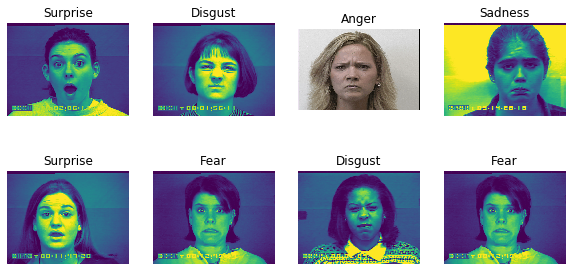

In [8]:
# Given image filename, return it's corresponding label from label_map
def label_util(filename, label_map):
    keys = filename.split('/')[-1].split('.')[0].split('_')
    label = label_map[keys[0] + '_' + keys[1]]
    return label

expressions = ['Anger','Contempt','Disgust','Fear','Happy','Sadness','Surprise']
idxs = np.random.randint(100, size=8)
f, a = plt.subplots(2, 4, figsize=(10, 5))

    
for i in range(8):
    image = io.imread(train_img_list[idxs[i]]) 
    r, c = i // 4, i % 4
    
    # Display an image
    label_no = label_util(train_img_list[idxs[i]], label_map)
    a[r][c].set_title(expressions[label_no])
    a[r][c].imshow(image)
    a[r][c].axis('off')

plt.show()

In [9]:
import logging
logging.basicConfig(filename="training_baseline.log" ,
                            filemode="a+")
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [10]:
# train_dataset, dev_dataset, test_dataset = torch.utils.data.random_split(dataset, (train_size, val_size, test_size))

In [11]:
# for i in range(len(train_dataset)):
#     print(train_dataset[i][0].shape)

In [12]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=4, 
                                               shuffle=True, num_workers=8)

dev_dataloader = torch.utils.data.DataLoader(dev_dataset, batch_size=4, 
                                               shuffle=True, num_workers=8)

In [13]:
class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
                          nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=kernel_size, stride=stride),
                          nn.ReLU(),
                          nn.MaxPool2d(2))
        
    def forward(self, x):
        return self.block(x)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class BaselineModel(nn.Module):
    def __init__(self, num_blocks):
        super(BaselineModel, self).__init__()
        layers = []
        num_classes = 7
        channels = [1, 64, 128, 256] # this needs to be modified according to num_blocks
        
        for i in range(num_blocks):
            layers.append(ConvBlock(C_in=channels[i], C_out=channels[i+1], kernel_size=5, stride=1))
        
        layers.append(nn.Dropout(p=0.25))
        
        layers.append(Flatten())
        
        layers.append(nn.Linear(256*24*24, 512))
        
        layers.append(nn.Dropout(p=0.5))
        
        layers.append(nn.Linear(512, num_classes))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [14]:
model = BaselineModel(num_blocks=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
print(model)

BaselineModel(
  (net): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): Dropout(p=0.25, inplace=False)
    (4): Flatten()
    (5): Linear(in_features=147456, out_features=512, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=7, bias=True)
  )
)


In [15]:
def train(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels.long())
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                logger.info('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
 
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_loss, train_accuracy = test_classify_loss(model,train_dataloader)
        test_loss, test_accuracy = test_classify_loss(model,test_loader)
        eval_losses.append(test_loss)
        train_losses.append(train_loss)
        eval_accs.append(test_accuracy)
        logger.info('Epoch: {}\tTrain Loss: {}\tTrain Acc: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, train_loss,train_accuracy, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_loss(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracies = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            accuracies += float(torch.sum(torch.eq(pred_labels, labels)).item())
            total+=float(len(labels))
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracies/total

In [16]:
train_losses, eval_losses, eval_accs = train(model,200, train_dataloader,dev_dataloader)

2019-11-13 09:59:43,002 root         INFO     Epoch: 1	Batch: 50	Avg-Loss: 3.2758
2019-11-13 09:59:45,671 root         INFO     Epoch: 1	Batch: 100	Avg-Loss: 1.9236
2019-11-13 09:59:51,202 root         INFO     Epoch: 1	Train Loss: 1.7554526432260795	Train Acc: 0.2835314091680815	Test-Loss: 1.7921638951009633	Test-acc: 0.2959
2019-11-13 09:59:54,764 root         INFO     Epoch: 2	Batch: 50	Avg-Loss: 1.8234
2019-11-13 09:59:57,522 root         INFO     Epoch: 2	Batch: 100	Avg-Loss: 1.8221
2019-11-13 10:00:03,354 root         INFO     Epoch: 2	Train Loss: 1.804728153403627	Train Acc: 0.2546689303904924	Test-Loss: 1.8132443719980669	Test-acc: 0.2959
2019-11-13 10:00:06,122 root         INFO     Epoch: 3	Batch: 50	Avg-Loss: 1.8163
2019-11-13 10:00:09,450 root         INFO     Epoch: 3	Batch: 100	Avg-Loss: 1.8200
2019-11-13 10:00:14,857 root         INFO     Epoch: 3	Train Loss: 1.7212001783536124	Train Acc: 0.2869269949066214	Test-Loss: 1.691025480932119	Test-acc: 0.3010
2019-11-13 10:00:1

2019-11-13 10:04:15,377 root         INFO     Epoch: 26	Batch: 100	Avg-Loss: 0.4830
2019-11-13 10:04:19,383 root         INFO     Epoch: 26	Train Loss: 0.009264899433569916	Train Acc: 0.99830220713073	Test-Loss: 3.6492707267099496	Test-acc: 0.5357
2019-11-13 10:04:21,546 root         INFO     Epoch: 27	Batch: 50	Avg-Loss: 0.0511
2019-11-13 10:04:23,443 root         INFO     Epoch: 27	Batch: 100	Avg-Loss: 0.1041
2019-11-13 10:04:27,718 root         INFO     Epoch: 27	Train Loss: 0.039691912095696495	Train Acc: 0.9932088285229203	Test-Loss: 3.9365226188484503	Test-acc: 0.4949
2019-11-13 10:04:30,025 root         INFO     Epoch: 28	Batch: 50	Avg-Loss: 0.0292
2019-11-13 10:04:32,293 root         INFO     Epoch: 28	Batch: 100	Avg-Loss: 0.0474
2019-11-13 10:04:38,840 root         INFO     Epoch: 28	Train Loss: 0.032327415178101414	Train Acc: 0.9881154499151104	Test-Loss: 3.7565405636417624	Test-acc: 0.4898
2019-11-13 10:04:41,550 root         INFO     Epoch: 29	Batch: 50	Avg-Loss: 0.1632
201

2019-11-13 10:09:27,068 root         INFO     Epoch: 52	Batch: 50	Avg-Loss: 0.0802
2019-11-13 10:09:29,482 root         INFO     Epoch: 52	Batch: 100	Avg-Loss: 0.0941
2019-11-13 10:09:35,930 root         INFO     Epoch: 52	Train Loss: 0.0017307812572537537	Train Acc: 1.0	Test-Loss: 4.901638235364642	Test-acc: 0.5357
2019-11-13 10:09:38,814 root         INFO     Epoch: 53	Batch: 50	Avg-Loss: 0.0677
2019-11-13 10:09:41,801 root         INFO     Epoch: 53	Batch: 100	Avg-Loss: 0.0998
2019-11-13 10:09:48,151 root         INFO     Epoch: 53	Train Loss: 0.0006783538844265638	Train Acc: 1.0	Test-Loss: 5.468125631614607	Test-acc: 0.5102
2019-11-13 10:09:51,163 root         INFO     Epoch: 54	Batch: 50	Avg-Loss: 0.0065
2019-11-13 10:09:54,501 root         INFO     Epoch: 54	Batch: 100	Avg-Loss: 0.0011
2019-11-13 10:10:00,122 root         INFO     Epoch: 54	Train Loss: 0.0008873162326262236	Train Acc: 1.0	Test-Loss: 5.445421701791335	Test-acc: 0.5102
2019-11-13 10:10:03,710 root         INFO     

2019-11-13 10:14:44,646 root         INFO     Epoch: 77	Train Loss: 0.003844291528335856	Train Acc: 0.99830220713073	Test-Loss: 4.9947952761942025	Test-acc: 0.5102
2019-11-13 10:14:47,626 root         INFO     Epoch: 78	Batch: 50	Avg-Loss: 0.0138
2019-11-13 10:14:50,379 root         INFO     Epoch: 78	Batch: 100	Avg-Loss: 0.0257
2019-11-13 10:14:56,883 root         INFO     Epoch: 78	Train Loss: 0.00026656735327935987	Train Acc: 1.0	Test-Loss: 6.155046040914496	Test-acc: 0.5204
2019-11-13 10:14:59,673 root         INFO     Epoch: 79	Batch: 50	Avg-Loss: 0.0033
2019-11-13 10:15:02,988 root         INFO     Epoch: 79	Batch: 100	Avg-Loss: 0.0055
2019-11-13 10:15:08,852 root         INFO     Epoch: 79	Train Loss: 0.0004743922546075844	Train Acc: 1.0	Test-Loss: 5.982484307824349	Test-acc: 0.5306
2019-11-13 10:15:12,377 root         INFO     Epoch: 80	Batch: 50	Avg-Loss: 0.1828
2019-11-13 10:15:15,696 root         INFO     Epoch: 80	Batch: 100	Avg-Loss: 0.1498
2019-11-13 10:15:21,318 root    

2019-11-13 10:19:32,153 root         INFO     Epoch: 103	Batch: 100	Avg-Loss: 0.0003
2019-11-13 10:19:37,758 root         INFO     Epoch: 103	Train Loss: 0.0067276784641026235	Train Acc: 0.9966044142614601	Test-Loss: 7.2687839366951765	Test-acc: 0.5306
2019-11-13 10:19:41,337 root         INFO     Epoch: 104	Batch: 50	Avg-Loss: 0.0896
2019-11-13 10:19:43,829 root         INFO     Epoch: 104	Batch: 100	Avg-Loss: 0.2848
2019-11-13 10:19:50,295 root         INFO     Epoch: 104	Train Loss: 0.007591811019819742	Train Acc: 0.99830220713073	Test-Loss: 9.012408684711067	Test-acc: 0.5408
2019-11-13 10:19:53,171 root         INFO     Epoch: 105	Batch: 50	Avg-Loss: 0.1384
2019-11-13 10:19:56,291 root         INFO     Epoch: 105	Batch: 100	Avg-Loss: 0.0694
2019-11-13 10:20:02,674 root         INFO     Epoch: 105	Train Loss: 0.002369412744389325	Train Acc: 1.0	Test-Loss: 7.332564928093735	Test-acc: 0.5408
2019-11-13 10:20:05,742 root         INFO     Epoch: 106	Batch: 50	Avg-Loss: 0.0726
2019-11-13

2019-11-13 10:24:50,278 root         INFO     Epoch: 129	Batch: 50	Avg-Loss: 0.0002
2019-11-13 10:24:52,683 root         INFO     Epoch: 129	Batch: 100	Avg-Loss: 0.0281
2019-11-13 10:24:59,236 root         INFO     Epoch: 129	Train Loss: 1.644076232392031e-05	Train Acc: 1.0	Test-Loss: 9.619634569907674	Test-acc: 0.5357
2019-11-13 10:25:02,032 root         INFO     Epoch: 130	Batch: 50	Avg-Loss: 0.0002
2019-11-13 10:25:05,048 root         INFO     Epoch: 130	Batch: 100	Avg-Loss: 0.0002
2019-11-13 10:25:11,405 root         INFO     Epoch: 130	Train Loss: 1.052927687536476e-05	Train Acc: 1.0	Test-Loss: 9.814755619788656	Test-acc: 0.5357
2019-11-13 10:25:14,428 root         INFO     Epoch: 131	Batch: 50	Avg-Loss: 0.0000
2019-11-13 10:25:17,745 root         INFO     Epoch: 131	Batch: 100	Avg-Loss: 0.0000
2019-11-13 10:25:23,372 root         INFO     Epoch: 131	Train Loss: 4.12233414188508e-06	Train Acc: 1.0	Test-Loss: 10.343968598210083	Test-acc: 0.5306
2019-11-13 10:25:26,981 root         

2019-11-13 10:30:07,763 root         INFO     Epoch: 154	Train Loss: 1.5870824532112162e-05	Train Acc: 1.0	Test-Loss: 10.638109231481748	Test-acc: 0.5561
2019-11-13 10:30:10,716 root         INFO     Epoch: 155	Batch: 50	Avg-Loss: 0.0066
2019-11-13 10:30:13,682 root         INFO     Epoch: 155	Batch: 100	Avg-Loss: 0.0000
2019-11-13 10:30:20,037 root         INFO     Epoch: 155	Train Loss: 1.4977058449503927e-05	Train Acc: 1.0	Test-Loss: 12.273263799900912	Test-acc: 0.5102
2019-11-13 10:30:23,026 root         INFO     Epoch: 156	Batch: 50	Avg-Loss: 0.0002
2019-11-13 10:30:26,353 root         INFO     Epoch: 156	Batch: 100	Avg-Loss: 0.0000
2019-11-13 10:30:31,967 root         INFO     Epoch: 156	Train Loss: 3.8474039229958086e-05	Train Acc: 1.0	Test-Loss: 12.2826651359091	Test-acc: 0.5204
2019-11-13 10:30:35,560 root         INFO     Epoch: 157	Batch: 50	Avg-Loss: 0.0026
2019-11-13 10:30:38,880 root         INFO     Epoch: 157	Batch: 100	Avg-Loss: 0.0006
2019-11-13 10:30:44,432 root     

2019-11-13 10:34:40,907 root         INFO     Epoch: 180	Batch: 50	Avg-Loss: 0.0000
2019-11-13 10:34:42,802 root         INFO     Epoch: 180	Batch: 100	Avg-Loss: 0.0000
2019-11-13 10:34:46,851 root         INFO     Epoch: 180	Train Loss: 3.238282908000849e-08	Train Acc: 1.0	Test-Loss: 14.32119038153668	Test-acc: 0.5561
2019-11-13 10:34:49,012 root         INFO     Epoch: 181	Batch: 50	Avg-Loss: 0.0270
2019-11-13 10:34:50,906 root         INFO     Epoch: 181	Batch: 100	Avg-Loss: 0.0376
2019-11-13 10:34:54,945 root         INFO     Epoch: 181	Train Loss: 0.02724076288867685	Train Acc: 0.9949066213921901	Test-Loss: 11.16485374801013	Test-acc: 0.5765
2019-11-13 10:34:57,110 root         INFO     Epoch: 182	Batch: 50	Avg-Loss: 0.1931
2019-11-13 10:34:59,046 root         INFO     Epoch: 182	Batch: 100	Avg-Loss: 0.0001
2019-11-13 10:35:03,088 root         INFO     Epoch: 182	Train Loss: 1.803723579756473e-06	Train Acc: 1.0	Test-Loss: 10.459009987967354	Test-acc: 0.5306
2019-11-13 10:35:05,253

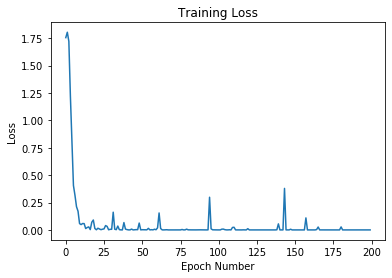

In [17]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.savefig("training_loss.png")

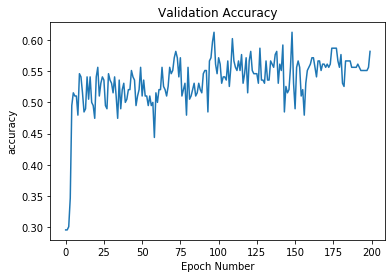

In [18]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('accuracy')
plt.plot(eval_accs)
plt.savefig("val_acc.png")